In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import fista
import timeit
from itertools import combinations
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# 1. Preliminaries

## Load basis functions

In [2]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels.  (~1.2 times overcomplete)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

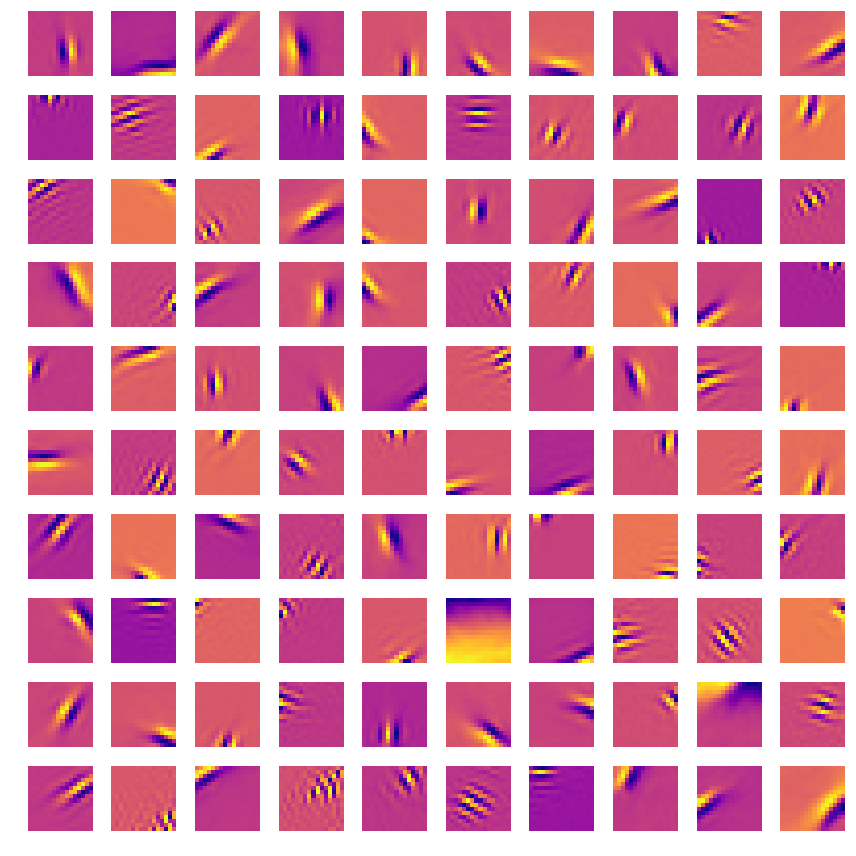

In [3]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [4]:
IMAGES = scipy.io.loadmat('IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

## Randomly select image patches

In [5]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I

In [162]:
I = sample_images(1, IMAGES)

## Find coefficients of sparse representation

In [163]:
ahat = fista.fista(I, bases, lambdav = 0.01, max_iterations=50)

In [8]:
print(np.sum(np.log(1 + ahat**2)))

print(np.sum(I-bases.dot(ahat))**2)

1.64028055676
0.656380122834


In [9]:
ahat_list = np.zeros([100, ahat.shape[0], ahat.shape[1]])

## Compute correlations between neuron pairs; plot as histogram

In [124]:
corr_list = []
neuron_pairs = combinations(range(300),2)

for i,j in neuron_pairs:
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    corr_list.append(corr)
    #if abs(corr) > 0.4 and i != j:
        #print(i,j)

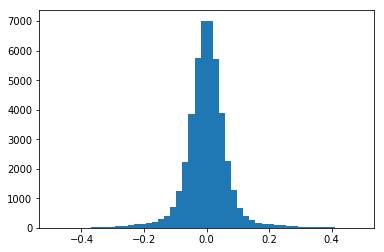

In [125]:
corr_hist = plt.hist(corr_list,50)
plt.show()

0.382198730186


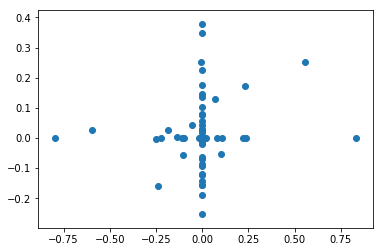

In [92]:
plt.scatter(ahat[56,:], ahat[148,:])
print(np.corrcoef(ahat[58,:], ahat[148,:])[0, 1])
plt.show()

In [12]:
def find_strong_image(neuron1, neuron2):
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > 0.1 and abs(ahat[neuron2,:][i]) > 0.1:
            return(i)
        
def find_strong_images(neuron1, neuron2, cutoff = 0.05):
    image_nums = []
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > cutoff and abs(ahat[neuron2,:][i]) > cutoff:
            image_nums.append(i)
    if len(image_nums) == 0:
        image_nums = find_strong_images(neuron1,neuron2, cutoff = cutoff - 0.05)
    return(image_nums)

In [13]:
print(find_strong_images(58,148))

[3, 5, 41, 96, 118, 124, 134, 143, 145, 166, 192, 200, 221, 252, 267, 273, 276, 300, 311, 336, 351, 401, 406, 417, 423, 449, 512, 517, 528, 543, 549, 597, 605, 607, 624, 638, 662, 667, 677, 686, 693, 699, 728, 753, 754, 758, 771, 774, 777, 782, 801, 802, 815, 818, 843, 855, 860, 861, 869, 917, 926, 927, 929, 936, 955, 956, 958, 964, 979, 983, 990, 994]


In [14]:
def add_noise(image, sigma = 1e-2):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

def plot_neurons(i,j, responses):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()

In [23]:
def get_noisy_responses(image):
    for i in range(100):
        ahat_list[i] = fista.fista(add_noise(image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
    """responses = np.zeros((bases.shape[1], num_trials))
    image_num = find_strong_image(neuron1, neuron2)  
    selected_image = np.reshape(I[:,image_num], (256,1))

    for i in range(num_trials):
        ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
        responses[:, i] = ahat2[:, 0]
        
    corr = np.corrcoef(responses[neuron1,:], responses[neuron2,:])[0, 1]
    
    return(corr)"""
    
def get_noise_correlations(neuron1, neuron2):
    corr = 0
    image_nums = find_strong_images(neuron1, neuron2)
    for image_num in image_nums:
        corr += np.corrcoef(ahat_list[:,neuron1,image_num], ahat_list[:,neuron2,image_num])[0, 1]
    return(corr/len(image_nums))
    

In [16]:
get_noisy_responses(I)

In [17]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    corr = get_noise_correlations(neuron1, neuron2)
    noise_corr_list.append(corr)

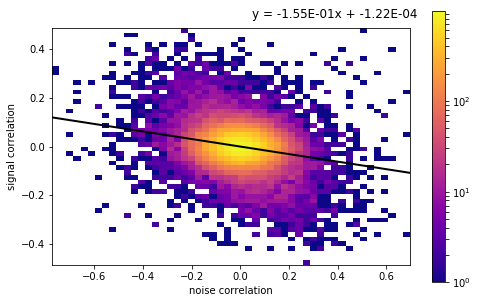

"plt.scatter(noise_corr_list, corr_list)\nplt.axis('equal')\nplt.show()"

In [364]:
fig, ax = plt.subplots(figsize = (8,5))
h = ax.hist2d(noise_corr_list, corr_list,(50,50), cmap = 'plasma', norm = LogNorm())
m,b = np.polyfit(noise_corr_list, corr_list, 1)
ax.plot([-1.0, 1.0], [-m + b, m + b], color='k', linestyle='-', linewidth=2)
s = 'y = {0:1.2E}x + {1:1.2E}'.format(m,b)
ax.text(0.05, 0.53, s, fontsize=12)
plt.xlabel('noise correlation')
plt.ylabel('signal correlation')
ax.set_aspect('equal')
plt.colorbar(h[3])

plt.savefig('foo2.png', bbox_inches='tight')
plt.show()

"""plt.scatter(noise_corr_list, corr_list)
plt.axis('equal')
plt.show()"""

In [342]:
ahat = fista.fista(I, bases, lambdav = 0.01, max_iterations=500)
#ahat = np.random.normal(0.0, 1e-2, size = ahat.shape)
print(U(ahat))
print(I.shape)

0.246935822724
(256, 1)


In [252]:
#print(0.01*np.sum(np.log(1 + ahat**2)))

grad = 0
for i in range(256):
    im = I[i]
    reco = bases.dot(ahat)[i]
    grad += 2*(im - reco)*(-bases[i,6])
    
print(grad)

#print(bases.shape)
print(np.sum((I - bases.dot(ahat))*(-2*bases), axis = 0))
    

#print(np.sum(np.abs(I-bases.dot(ahat))))

[-0.010]
[0.010 0.007 0.000 0.007 -0.000 -0.010 -0.010 0.005 -0.010 0.008 -0.004
 -0.000 -0.009 0.010 -0.010 -0.010 0.010 0.001 0.003 -0.002 0.010 0.005
 -0.010 -0.000 -0.000 -0.008 0.010 -0.002 -0.003 0.010 0.001 -0.010 0.010
 0.010 -0.010 0.010 0.004 -0.005 -0.010 -0.010 0.010 0.010 -0.010 0.010
 0.010 -0.010 -0.010 0.000 0.010 0.006 -0.005 0.010 -0.010 -0.010 0.010
 -0.010 -0.007 0.008 0.010 -0.010 -0.009 -0.000 -0.006 0.003 -0.009 0.010
 -0.010 0.010 0.010 0.010 -0.003 0.010 -0.010 -0.010 -0.010 -0.004 0.010
 0.010 0.008 0.010 -0.010 0.010 -0.008 -0.010 -0.005 -0.010 -0.002 0.010
 -0.003 -0.002 -0.010 0.010 -0.000 -0.010 -0.010 -0.010 0.010 -0.010 -0.010
 0.009 -0.010 -0.006 0.007 -0.003 -0.010 0.003 -0.010 -0.008 -0.010 -0.010
 0.003 0.010 0.007 0.010 0.010 0.010 0.010 0.010 0.001 -0.006 -0.010 0.010
 -0.006 -0.010 -0.010 0.010 -0.010 0.010 -0.010 0.010 -0.010 0.007 0.010
 0.010 0.009 0.010 -0.010 -0.010 -0.010 0.007 0.001 0.008 0.005 0.010
 -0.010 0.010 0.010 0.010 -0.010 0.010 -

In [336]:
def U(q, Phi = bases, lambdav = 0.01 ):
    
    return np.sum((I-Phi.dot(q))**2) + lambdav*np.sum(np.log(1 + ahat**2)) #lambdav*np.sum(np.abs(q)) np.sum(I-Phi.dot(q))**2 +

def grad_U(q, Phi = bases, lambdav = 0.01):
    
    grad = np.zeros(q.shape)
    
    #print(Phi[:,0].shape)
    #print(Phi[:,0])
    #print(np.abs(I - Phi.dot(q)))
    reco_grad = np.sum((I - bases.dot(ahat))*(-2*bases), axis = 0)
    for i in range(300):
        grad[i,:] =  lambdav*2*q[i]/(1 + q[i]**2) + reco_grad[i]
    #grad += 2*np.sum(np.abs(I-Phi.dot(q)))*(-Phi) 
    
    
    return(grad)

def grad_U2(q, Phi = bases,  lambdav = 0.01):
    
    grad = np.zeros(q.shape)
    
    
    for i in range(300):
        dq = np.zeros(q.shape)
        dq[i,:] = 1e-2
        grad[i,:] = (U(q + dq, Phi , lambdav ) - U(q - dq, Phi , lambdav))/2e-2

    return(grad)

print(grad_U(ahat, bases,  0.01)[:5])
print(grad_U2(ahat, bases,  0.01)[:5])
#print(U(ahat, bases, 0.01))
#print(U(ahat + grad_U(ahat, bases,  0.1), bases, 0.1))
#print(dU(ahat, bases, I, 10000))

[[0.722]
 [1.214]
 [0.411]
 [0.425]
 [-0.032]]
[[0.722]
 [1.215]
 [0.411]
 [0.425]
 [-0.032]]


# HMC algorithm

In [338]:
def HMC(epsilon, L, current_q):
    q = current_q
    p = 2e-2*np.random.normal(size = q.shape)
    current_p = p
    
    # Make a half step for momentum
    
    p += -epsilon*grad_U(q)/2
    
    # Alternate full steps for position and momentum
    
    for i in range(L):
        
        # Make a full step for the position
        
        q += epsilon*p
        
        # Make a full step for momentum, except at end of trajectory
        
        if i != L-1:
            
            p += -epsilon*grad_U(q)
            
    # Make a half step for momentum at the end
    
    p += -epsilon*grad_U(q)/2
    
    
    current_U = U(current_q)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = np.sum(p**2) / 2
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    #print(np.exp(current_U-proposed_U+current_K-proposed_K))
    rando = np.random.uniform()
    #print(rando)
    if (rando < np.exp(current_U-proposed_U+current_K-proposed_K)):
        
        return q #accept
    
    else:
        return current_q # reject


In [332]:
ps = []

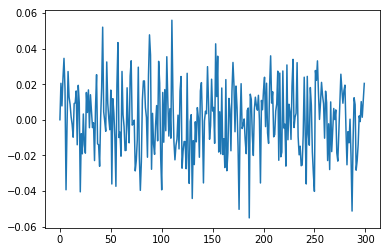

In [330]:
#print(ps[:][1])
plt.plot(ps[:][1])
plt.show()

In [346]:
old_sample=ahat
samplelist6 = np.zeros([1000,300,1])
print(U(old_sample, bases, 0.01))
energies6 = []

0.2590778331


In [347]:
for i in range(1000):
    if i % 100 ==0:
        print(i)
    #print(U(old_sample, bases, 0.01))
    energies6.append(U(old_sample, bases, 0.01))
    new_sample = HMC(0.1,50, old_sample)
    #print(new_sample[1])
    samplelist6[i,:,:] = new_sample
    old_sample = new_sample
   

0
100
200
300
400
500
600
700
800
900


In [218]:
samplelist3 = np.zeros([40000,300,1])

In [221]:
for i in range(40000):
    if i < 20000:
        samplelist3[i,:,:] = samplelist[i,:,:] 
    else:
        samplelist3[i,:,:] = samplelist2[i - 20000,:,:]
    

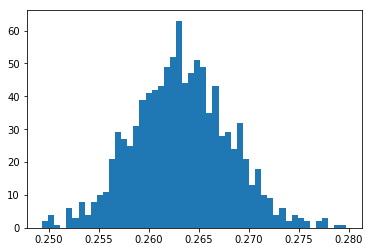

In [348]:
plt.hist(energies6,bins=50)
plt.show()

0.00600115296947
0.00689916869931
0.00542935740186
0.00696294689429
0.00277752755468
0.00836342541139
0.0108447093726
0.00729508950663
0.00678732111972
0.0067489751068
[[0.006]
 [0.007]
 [0.005]
 [0.007]
 [0.003]
 [0.008]
 [0.011]
 [0.007]
 [0.007]
 [0.007]]


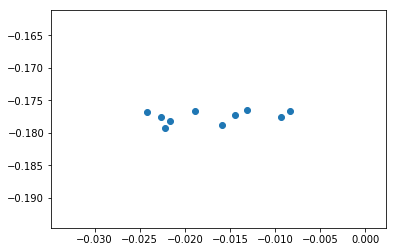

In [71]:
for j in samplelist:
    print(j[1][0])

print(samplelist[:,1,:])
plt.scatter(samplelist[:,4,:],samplelist[:,5,:])
plt.show()

In [360]:
def get_noise_correlations(neuron1, neuron2, noisy_responses):
    #plt.scatter(noisy_responses[:,neuron1,0],noisy_responses[:,neuron2,0])
    #plt.show()
    corr = np.corrcoef(noisy_responses[:,neuron1,0],noisy_responses[:,neuron2,0])[0, 1]
    #if corr > 0.4:
        #print(neuron1, neuron2)
    return(corr)
    

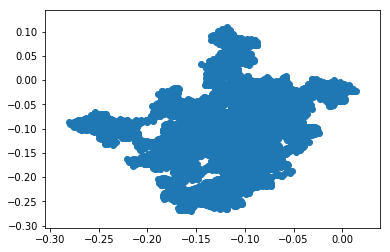

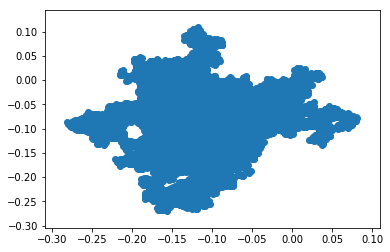

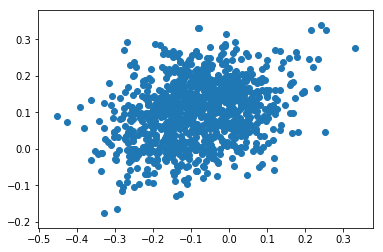

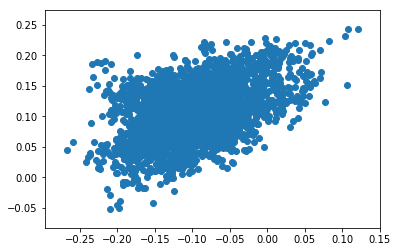

7 122


0.45949070920244167

In [359]:
get_noise_correlations(2,3,samplelist)
get_noise_correlations(2,3,samplelist3)
get_noise_correlations(7,122,samplelist6)
get_noise_correlations(7,122,samplelist5)

In [355]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    corr = get_noise_correlations(neuron1, neuron2, samplelist5)
    noise_corr_list.append(corr)

0 237
2 98
5 135
6 190
7 122
10 234
13 65
14 143
17 273
18 114
21 46
21 282
22 149
22 191
24 38
29 53
29 220
34 200
34 273
35 248
37 156
38 55
42 228
43 264
45 170
46 282
50 263
56 76
57 125
57 269
59 63
59 74
63 74
63 252
65 93
66 296
67 148
67 278
68 126
68 262
69 136
70 87
72 229
73 294
74 221
77 161
78 223
78 258
79 87
80 114
82 185
83 263
86 248
89 95
89 115
89 124
89 201
90 173
94 125
94 183
95 280
96 168
96 255
97 234
104 211
104 262
105 151
105 213
108 256
109 168
110 222
113 273
114 153
115 230
117 287
121 138
125 183
125 269
130 170
130 297
131 201
135 252
135 275
143 195
146 185
148 203
148 278
149 191
149 245
150 217
151 213
151 286
154 295
156 250
156 291
160 190
170 206
175 266
178 225
200 229
202 210
203 278
206 268
207 244
207 284
213 286
220 228
224 234
224 294
244 284
252 271
258 280
277 293
288 290


In [194]:
def fancy_scatter(x,y):    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

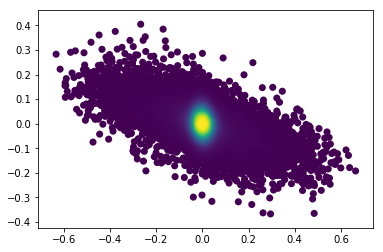

In [202]:
x = np.array(noise_corr_list)
y = np.array(corr_list)
fancy_scatter(x,y)

[-0.111 -0.132 -0.157 -0.112 -0.127 -0.139 -0.158 -0.179 -0.111 -0.150
 -0.164 -0.145 -0.155 -0.171 -0.147 -0.149 -0.149 -0.155 -0.159 -0.151
 -0.154 -0.141 -0.133 -0.127 -0.166 -0.147 -0.168 -0.152 -0.138 -0.127
 -0.166 -0.154 -0.153 -0.134 -0.139 -0.113 -0.120 -0.129 -0.156 -0.160
 -0.156 -0.168 -0.137 -0.148 -0.149 -0.153 -0.164 -0.148 -0.145 -0.153
 -0.156 -0.147 -0.129 -0.172 -0.145 -0.141 -0.138 -0.129 -0.124 -0.139
 -0.133 -0.179 -0.130 -0.134 -0.131 -0.110 -0.161 -0.133 -0.160 -0.146
 -0.140 -0.146 -0.128 -0.152 -0.103 -0.164 -0.143 -0.132 -0.129 -0.139
 -0.111 -0.140 -0.132 -0.121 -0.159 -0.149 -0.140 -0.134 -0.124 -0.114
 -0.130 -0.156 -0.175 -0.125 -0.150 -0.126 -0.126 -0.126 -0.158 -0.149]


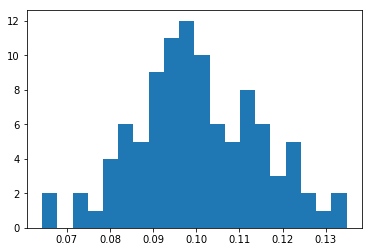

In [119]:
print(ahat_list[:,0,3])
plt.hist(ahat_list[:,0,8], 20)
plt.show()

-0.295571891613


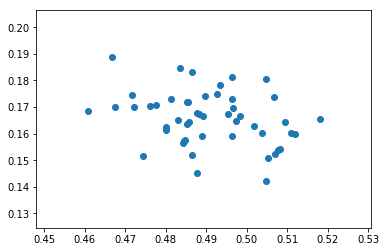

In [74]:
plot_neurons(58,148, responses)

# Signal correlation vs noise correlation

In [84]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    noise_corr_list.append(get_noise_correlation(neuron1, neuron2))
    

KeyboardInterrupt: 

In [ ]:
corr_hist = plt.hist(noise_corr_list,50)
plt.show()

## Extras

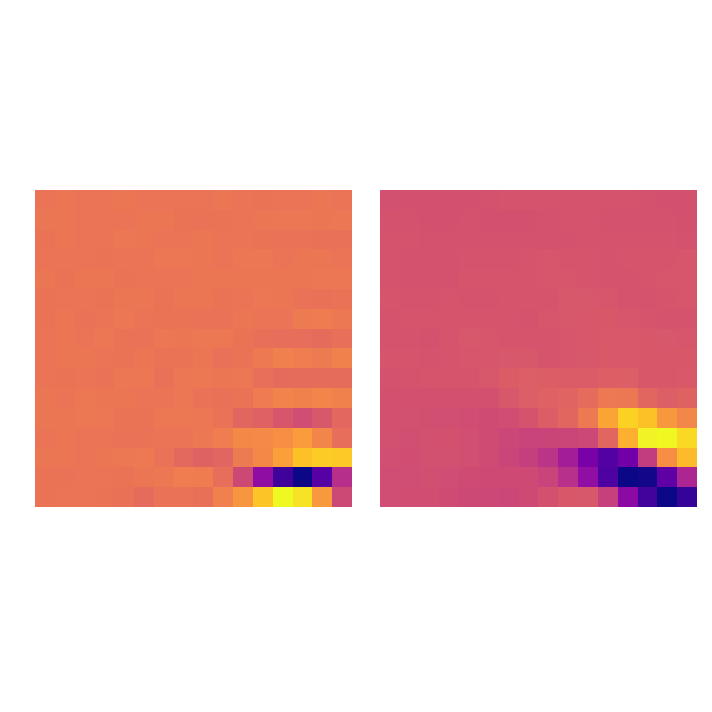

In [50]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10,10), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [67,81]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

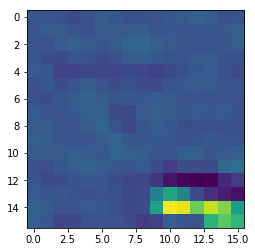

In [51]:
plt.imshow(np.reshape(I[:,835], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

256


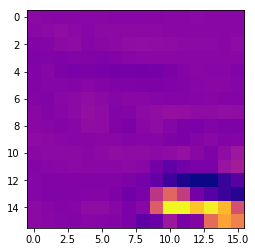

In [52]:
reco = np.dot(bases, responses[:, 1])
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
print(reco.size)
plt.show()

In [53]:
print(ahat.shape)

(300, 1000)


67
81
159
190
203
264


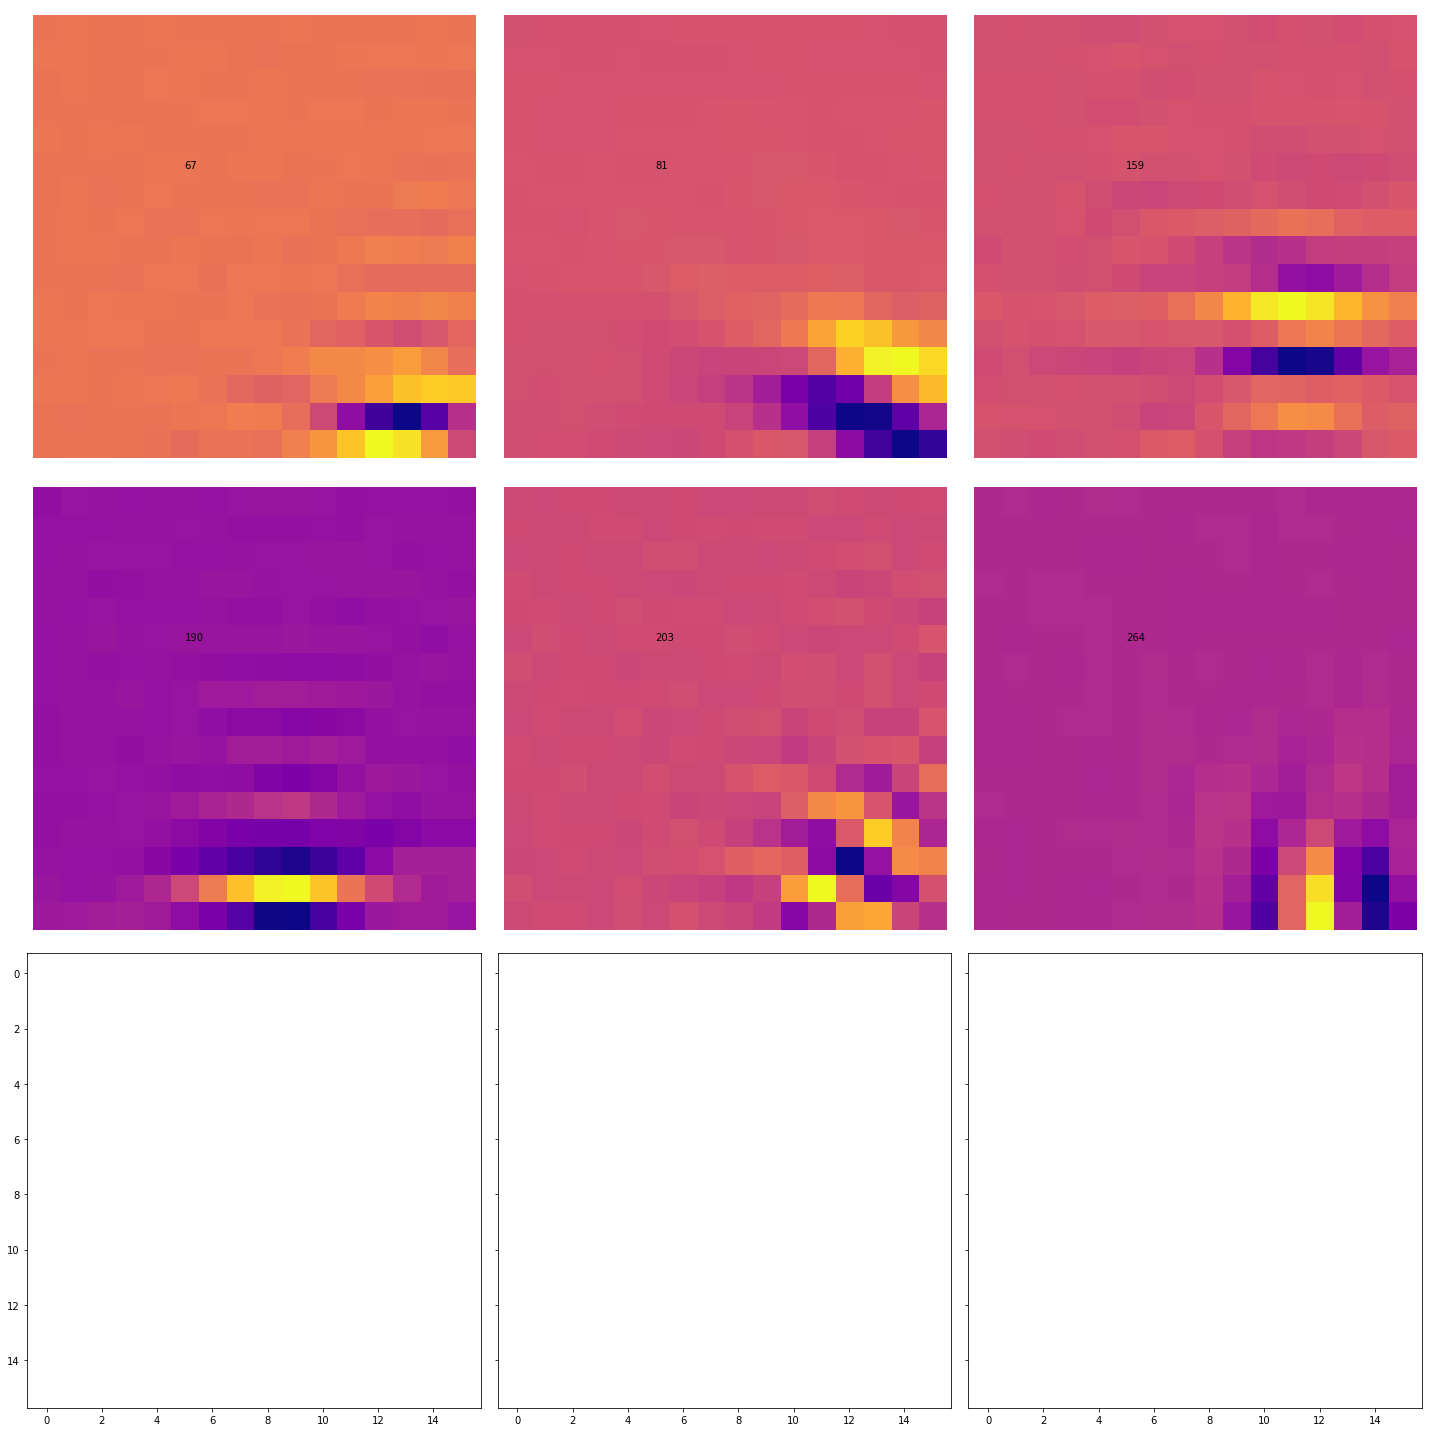

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i,835]) > 0.3:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

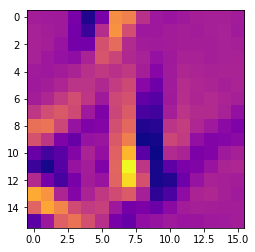

In [74]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [47]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

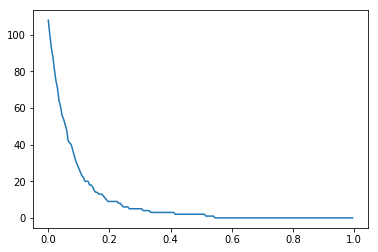

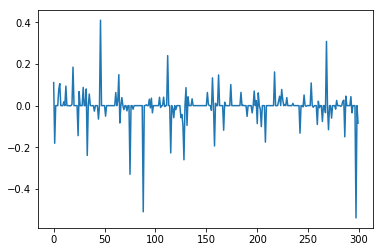

In [33]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()